In [1]:
import torch
import sar_clip

In [2]:
#download model to ./sar_clip/model_configs
model_name = 'ViT-B-32' #select from ['RN50', 'RN101', 'ViT-B-16', 'ViT-B-32', 'ViT-L-14']
model_path = r'./sar_clip/model_configs/ViT-B-32/vit_b_32_model.safetensors'
cache_dir= r"./sar_clip/model_configs/ViT-B-32"
model = sar_clip.create_model_with_args(model_name, pretrained=model_path)
model.eval()
tokenizer = sar_clip.get_tokenizer(model_name, cache_dir=cache_dir)

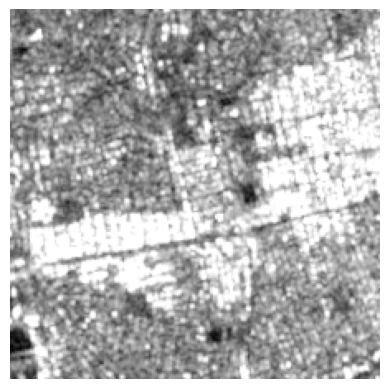

In [3]:
# Load image and tokenize text
image_path = r".\winter_138_p296_16_16.tif"
image = sar_clip.readtif(image_path)
sar_clip.display(image)
image = torch.from_numpy(image)
image = image.unsqueeze(0)
text = [
    "an SAR image of urban zones",
    "an SAR image of water areas",
    "an SAR image of croplands",
    "one solitary marine craft is visible in the right region .",
    "along the right side , several storage tanks are be detected .",
    "1 aircraft is found throughout the frame ."
]
tokenized_text = tokenizer(text)

In [4]:
# Perform inference with the model
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

In [5]:
# Format the output as requested, with the probabilities rounded to 4 decimal places
formatted_output = [
    f"{label:<50} {prob:.4f}"
    for label, prob in zip(text, text_probs[0].numpy())
]

# Print the formatted predictions
print("Predictions:")
for line in formatted_output:
    print(line)

Predictions:
an SAR image of urban zones                        1.0000
an SAR image of water areas                        0.0000
an SAR image of croplands                          0.0000
one solitary marine craft is visible in the right region . 0.0000
along the right side , several storage tanks are be detected . 0.0000
1 aircraft is found throughout the frame .         0.0000
